In [1]:
# Install packages
!pip install mplsoccer==1.2.4 --quiet
!pip install tqdm==4.66.4 --quiet

In [2]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplsoccer as mpl
import sklearn.cluster as cluster
import sklearn.metrics as metrics

from copy import deepcopy
from tqdm import tqdm

In [3]:
# Initialise environment
seed = 27

# Introduction
---

The aim of this script is to take K-Means clustering of passes a step further than the tutorials provided by [Soccermatics](https://soccermatics.readthedocs.io/en/latest/gettingstarted.html) and [Devin Pleuler](https://github.com/devinpleuler/analytics-handbook?tab=readme-ov-file). At the beginning of this script I retain a healthy amount of scepticism as to the usefulness of the method, but there's two specific areas that I think are worth considering in greater detail before I finalise that conclusion:

* Positional clustering (i.e., creating passing clusters for specific positions individually)
* Additional preprocessing of data prior to clustering (e.g., reflecting actions, removing set pieces/goal kicks)

I'll look at these steps individually. As this notebook is being produced locally, it isn't limited by Google Colabs processing time so I'll use a full season of StatsBomb 2015/16 La Liga data.

# Import data
---

Import using the Sbopen() parser again. Like last time, we want competition_id = 11, season_id = 27. We can get the event data again, but let's include some player name and position data as well this time.

In [4]:
# Assign the parser
sb_parser = mpl.Sbopen()

# Get La Liga matches and convert to dictionary for processing
# orient="records" keeps all rows of the dataframe together within the dictionary
laliga_matches = sb_parser.match(competition_id=11, season_id=27)
laliga_dict = laliga_matches.to_dict(orient = "records")

In [5]:
# Create list for all events
all_events = []

# Loop through the dictionary of matches
for m in tqdm(laliga_dict):
  # Get event data
  events = sb_parser.event(match_id = m["match_id"])[0]
  # Filter down to passes
  passes = events.loc[events["type_name"] == "Pass"].copy()
  # Get the data we want. Include player and position this time so we can filter/check similarities
  event_data = np.vstack((passes["player_name"], passes["position_name"], passes["x"], passes["y"], passes["end_x"], passes["end_y"])).T
  # Add them to the list of all events
  all_events.extend(event_data)

# Put coordinates into dataframe
passes_df = pd.DataFrame(all_events, columns=["player", "position", "x1", "y1", "x2", "y2"])
passes_df.head(3)

100%|█████████████████████████████████████████| 380/380 [04:04<00:00,  1.56it/s]


,player,position,x1,y1,x2,y2
0,Adrián González Morales,Center Attacking Midfield,61.0,40.1,62.1,47.3
1,Borja González Tomás,Center Forward,61.2,41.3,59.1,38.0
2,Daniel García Carrillo,Left Defensive Midfield,49.2,33.5,32.3,58.4


# Positional Pass Clustering
---

We'll start by looking at central midfielders since they are likely to have the most passes. I'll assume that there are five types of central midfielder for the purposes of this analysis and look to cluster by the passes they make, rather than using the different types of central midfielder in different analyses: 

* "Center Attacking Midfield"
* "Left Center Midfield", "Center Midfield", "Right Center Midfield"
* "Center Defensive Midfield"

The code below takes the central midfielders we want, then runs a loop of K-means clustering analyses before plotting the results so we can identify the optimum number of clusters.


In [6]:
# Filter data
cms = ["Center Attacking Midfield", "Left Center Midfield", "Center Midfield", "Right Center Midfield", "Center Defensive Midfield"]
cm_passes_df = passes_df.loc[passes_df["position"].isin(cms)].copy()

100%|███████████████████████████████████████████| 36/36 [09:06<00:00, 15.19s/it]


Text(0.5, 0, 'Number Centroids')

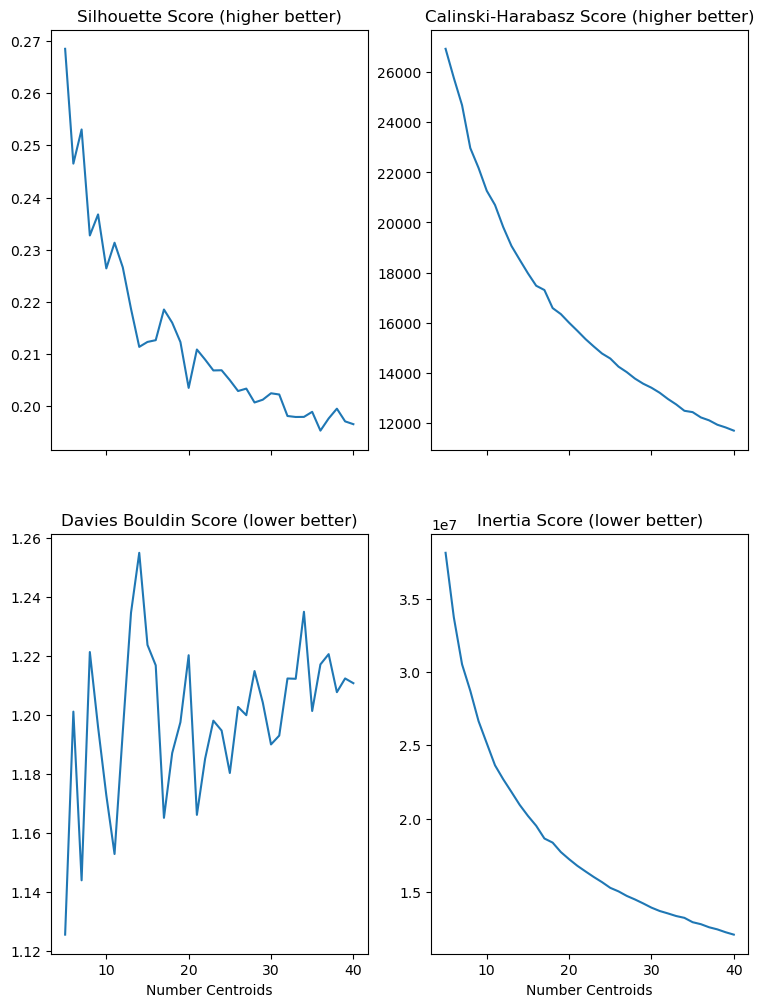

In [7]:
# K-Means features and clusters
kmeans_features = cm_passes_df[["x1", "y1", "x2", "y2"]]
clusters = list(range(5, 41, 1))

# K-Means loop results list
inertias = []
silhouettes = []
calinski_harabasz = []
davies_bouldin = []

# Run k-means for all cluster sizes from 5 to 40 clusters.
for i in tqdm(clusters):
  # Run the kmeans algorithm
  kmeans = cluster.KMeans(n_clusters=i, random_state=seed).fit(kmeans_features)

  # Add the metrics to their respective lists
  inertias.append(kmeans.inertia_)
  silhouettes.append(metrics.silhouette_score(kmeans_features, kmeans.labels_, metric='euclidean'))
  calinski_harabasz.append(metrics.calinski_harabasz_score(kmeans_features, kmeans.labels_))
  davies_bouldin.append(metrics.davies_bouldin_score(kmeans_features, kmeans.labels_))

# Create the metrics figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), sharex=True)

# Silhouette scores
axs[0,0].plot(clusters, silhouettes)
axs[0,0].set_title("Silhouette Score (higher better)")
# Calinski-Harabasz scores
axs[0,1].plot(clusters, calinski_harabasz)
axs[0,1].set_title("Calinski-Harabasz Score (higher better)")
# Davies Bouldin scores
axs[1,0].plot(clusters, davies_bouldin)
axs[1,0].set_title("Davies Bouldin Score (lower better)")
# Inertia scores
axs[1,1].plot(clusters, inertias)
axs[1,1].set_title("Inertia Score (lower better)")

# Label the shared x-axes
axs[1,0].set_xlabel("Number Centroids")
axs[1,1].set_xlabel("Number Centroids")

It's not that easy to see which is the most appropriate cut-off here because the Davies Bouldin score, in particular, is really fuzzy. There appear to be 3 possible points based on the Silhouette score, an initial elbow at approximately 30 centres (probably 32) and then two peaks which are preceded or followed by drops depending on which way you are reading the graph. The two peaks are approximately at 22 centres (drop around 20) and 17 (drop around 13-15). Let's plot the three possible options and see how they look. Strictly speaking I think the first elbow is at 30, but it's possible that this will be too many clusters just for central midfielders.

Text(0.5, 1.0, '32 clusters')

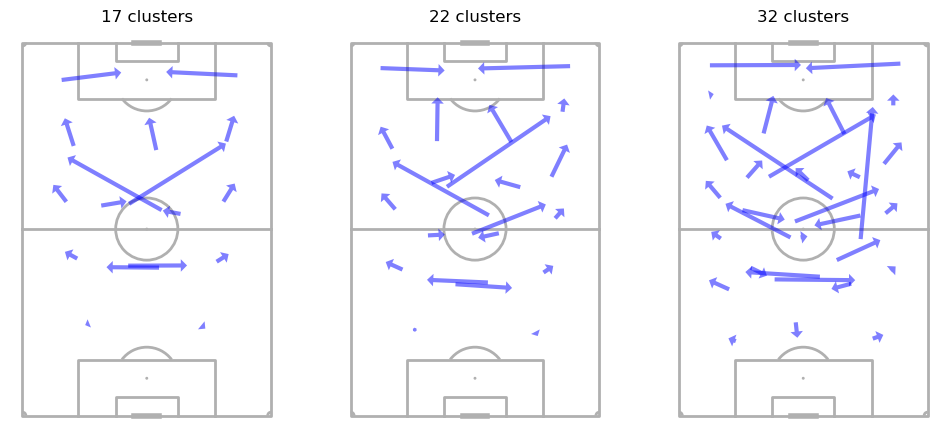

In [8]:
# First re-run models so we have the clusters (maybe I should have saved them in a list previously)
kmeans17_fit = cluster.KMeans(n_clusters=17, random_state=seed).fit(kmeans_features)
kmeans22_fit = cluster.KMeans(n_clusters=22, random_state=seed).fit(kmeans_features)
kmeans32_fit = cluster.KMeans(n_clusters=32, random_state=seed).fit(kmeans_features)

# Plot the figure using a very similar code to those we have previously used
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Create the pitches
# Notice how the axs argument has two parts now - a row index and a column index
pitch = mpl.VerticalPitch(corner_arcs=True)
pitch.draw(ax=axs[0])
pitch.draw(ax=axs[1])
pitch.draw(ax=axs[2])

# Loop through each fitted object plotting arrows in the appropriate plot
for coords in kmeans17_fit.cluster_centers_:
  kmeans17_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[0],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in kmeans22_fit.cluster_centers_:
  kmeans22_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in kmeans32_fit.cluster_centers_:
  kmeans32_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[2],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)

# Add plot titles
axs[0].set_title("17 clusters")
axs[1].set_title("22 clusters")
axs[2].set_title("32 clusters")


As I suspected, the 32 cluster model looks a bit cluttered, but I feel like these are beautiful representations of the passes made by midfielders. Maybe there is some benefit when using K-Means clustering to understand passes after all! The 17 cluster model is extremely clear and beautifully simplistic (in my potentially biased opinion). However, the OCD in me is upset by the lack of symmetry in the clusters. There's no reason why things shouldn't be symmetrical when they are that close to it, so let's try and address that.

# Symmetrical Positional Pass Clustering

We can constrain the model to be symmetrical by preprocessing the data to consider passes in relation to the mid-line. This way, taking the example of the "crosses" above, both left and right sides of the pitch will contribute to the same cluster. I can reflect all clusters about the x-axis as we look (the y-axis according to the cm_passes_df dataframe) so that they are symmetrical. This will require a bunch of transformations though.

In [9]:
# StatsBomb standardises coordinates to a 120x80 pitch.
# This is slightly confusing for us in this notebook because I've plotted the x and y axes reversed above, but take it from me that we need
# to flip the y-axis values around 40 (half of 80) and keep the x-axis values the same.
# First, create new x-axis variables and centre the y-axis variables around 40 
# Immediately call x-axis variables "reflected" as nothing more needs doing
cm_passes_df["reflected_x1"] = cm_passes_df["x1"].copy()
cm_passes_df["reflected_x2"] = cm_passes_df["x2"].copy()
# Call y-axis variables "flipped" so we can perform transformation next time. This could probably be done as one step, but keeping at two for
# clarity.
cm_passes_df["flipped_y1"] = cm_passes_df["y1"] - 40
cm_passes_df["flipped_y2"] = cm_passes_df["y2"] - 40

# Next, we want to reflect around the midline. We can do this using an if else np.where statement.
cm_passes_df["reflected_y1"] = np.where(cm_passes_df["flipped_y1"] < 0, cm_passes_df["flipped_y1"], -1*cm_passes_df["flipped_y1"])
cm_passes_df["reflected_y2"] = np.where(cm_passes_df["flipped_y2"] < 0, cm_passes_df["flipped_y2"], -1*cm_passes_df["flipped_y2"])

100%|███████████████████████████████████████████| 16/16 [04:06<00:00, 15.40s/it]


Text(0.5, 0, 'Number Centroids')

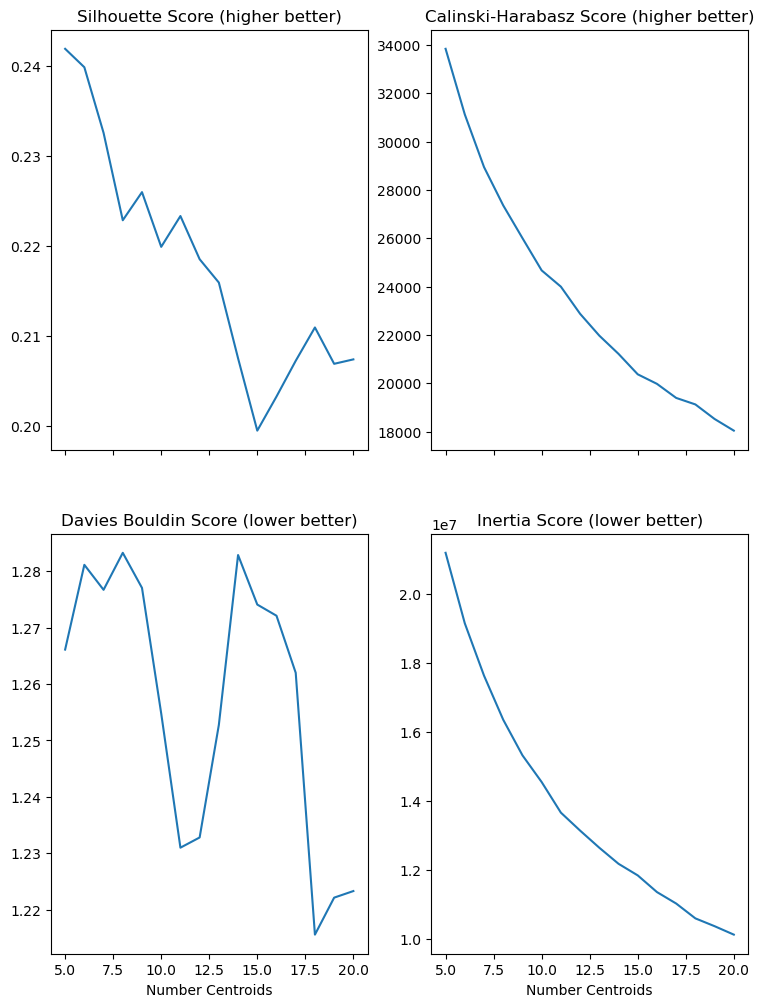

In [10]:
# Now I'll re-run the K-Means clusters, with the new data. We won't need as many clusters and I'll save the models this time.
kmeans_features = cm_passes_df[["reflected_x1", "reflected_y1", "reflected_x2", "reflected_y2"]]
clusters = list(range(5, 21, 1))

# K-Means loop results list
models = []
inertias = []
silhouettes = []
calinski_harabasz = []
davies_bouldin = []

# Run k-means for all cluster sizes from 5 to 40 clusters.
for i in tqdm(clusters):
  # Run the kmeans algorithm
  kmeans = cluster.KMeans(n_clusters=i, random_state=seed).fit(kmeans_features)

  # Add the model to the list
  models.append(kmeans)
  # Add all the metrics to the
  inertias.append(kmeans.inertia_)
  silhouettes.append(metrics.silhouette_score(kmeans_features, kmeans.labels_, metric='euclidean'))
  calinski_harabasz.append(metrics.calinski_harabasz_score(kmeans_features, kmeans.labels_))
  davies_bouldin.append(metrics.davies_bouldin_score(kmeans_features, kmeans.labels_))

# Create the metrics figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), sharex=True)

# Silhouette scores
axs[0,0].plot(clusters, silhouettes)
axs[0,0].set_title("Silhouette Score (higher better)")
# Calinski-Harabasz scores
axs[0,1].plot(clusters, calinski_harabasz)
axs[0,1].set_title("Calinski-Harabasz Score (higher better)")
# Davies Bouldin scores
axs[1,0].plot(clusters, davies_bouldin)
axs[1,0].set_title("Davies Bouldin Score (lower better)")
# Inertia scores
axs[1,1].plot(clusters, inertias)
axs[1,1].set_title("Inertia Score (lower better)")

# Label the shared x-axes
axs[1,0].set_xlabel("Number Centroids")
axs[1,1].set_xlabel("Number Centroids")

Again, it's maybe not clear, but let's look at 11 clusters as this corresponds with a peak in Silhouette score and trough in Davies Bouldin score - both positive elements for their respective metrics. As the models started at 5 centroids, the 11 cluster model is the 6th entry in the list.

Text(0.5, 1.0, 'Reflected Clusters')

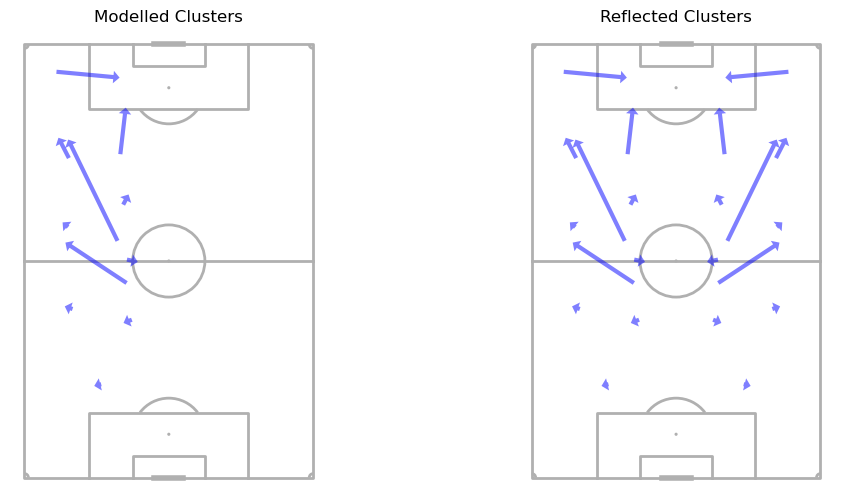

In [11]:
# Create the coordinate values
# cluster_centers[:, 0] and [:, 2] are x values so stay the same
# cluster_centers[:, 1] and [:, 3] are y values so need to be re-centered for plotting
modelled_clusters = np.array([models[6].cluster_centers_[:, 0],
                              models[6].cluster_centers_[:, 1] + 40,
                              models[6].cluster_centers_[:, 2],
                              models[6].cluster_centers_[:, 3] + 40]).T

reflected_clusters = np.array([models[6].cluster_centers_[:, 0],
                              -1*models[6].cluster_centers_[:, 1] + 40,
                              models[6].cluster_centers_[:, 2],
                              -1*models[6].cluster_centers_[:, 3] + 40]).T
                             

# Set up the figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Create the pitches
# Notice how the axs argument has two parts now - a row index and a column index
pitch = mpl.VerticalPitch(corner_arcs=True)
pitch.draw(ax=axs[0])
pitch.draw(ax=axs[1])

# Loop through each fitted object plotting arrows in the appropriate plot
for coords in modelled_clusters:
  kmeansmod_p0 = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[0],
                              headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
  kmeansmod_p1 = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1],
                              headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in reflected_clusters:
  kmeansref_p1 = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1],
                              headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
    
# Add plot titles
axs[0].set_title("Modelled Clusters")
axs[1].set_title("Reflected Clusters")

#models[6].cluster_centers_

The plot above shows the modelled clusters (every action reflected to the left side of the pitch) and the implied full pitch model (modelled clusters and reflected clusters). We can see it hasn't worked completely as hoped. The smaller arrows in the centre of the pitch don't look right and could be relective of the co-ordinate flipping procedure reducing the length of some of the passes. If we look at the plots above, we can see that the passes just below the halfway line would have crossed the 40m reflection point, so the reflection that we did is essentially cutting them in half. 

To resolve this problem, let's modify the co-ordinate reflection rule and work using the centre line at 40 rather than 0 (it took me a little while to figure this out and was easier using the "real" numbers). We will now work with two rules - remember we are working with the y-axis because that's what StatsBomb uses for the horizontal component of the plots above):

* If both y co-ordinates are greater than 40, flip both.
* If y1 co-ordinate is greater than 40, y2 co-ordinate is less than y1 and y2 co-ordinate is less than 40, reflect the co-ordinates (remember StatsBomb has reversed co-ordinate system to us).

In [12]:
# Let's do this slightly differently, using a function instead of individual lines of code. 
def reflect_vectors(df):

    # Both co-ordinates greater than 40 (i.e., both on right side of pitch)
    both_greater = ((df["y1"] > 40) & (df["y2"] > 40))
    # Start on right side of pitch (y1 > 40) but pass to the left (y2 < y1), across the centre of the pitch (y2 < 40)
    pass_left = ((df["y1"] > 40) & (df["y2"] < df["y1"]) & (df["y2"] < 40))

    # Initialise reflected columns
    df["reflected_y1"] = df["y1"]
    df["reflected_y2"] = df["y2"]

    # Reflect about y = 0
    df.loc[both_greater, "reflected_y1"] = 40 - (df.loc[both_greater, "y1"] - 40)
    df.loc[both_greater, "reflected_y2"] = 40 - (df.loc[both_greater, "y2"] - 40)
    df.loc[pass_left, "reflected_y1"] = 40 - (df.loc[pass_left, "y1"] - 40)
    df.loc[pass_left, "reflected_y2"] = 40 - (df.loc[pass_left, "y2"] - 40)

    return df

# Start from scratch with new dataframe
cm_sym_passes_df = passes_df.loc[passes_df["position"].isin(cms)].copy()

# Create reflected x-axis values as these won't change
cm_sym_passes_df["reflected_x1"] = cm_sym_passes_df["x1"].copy()
cm_sym_passes_df["reflected_x2"] = cm_sym_passes_df["x2"].copy()

# Run the function on the dataframe
cm_sym_passes_df = reflect_vectors(cm_sym_passes_df)

100%|███████████████████████████████████████████| 16/16 [04:07<00:00, 15.45s/it]


Text(0.5, 0, 'Number Centroids')

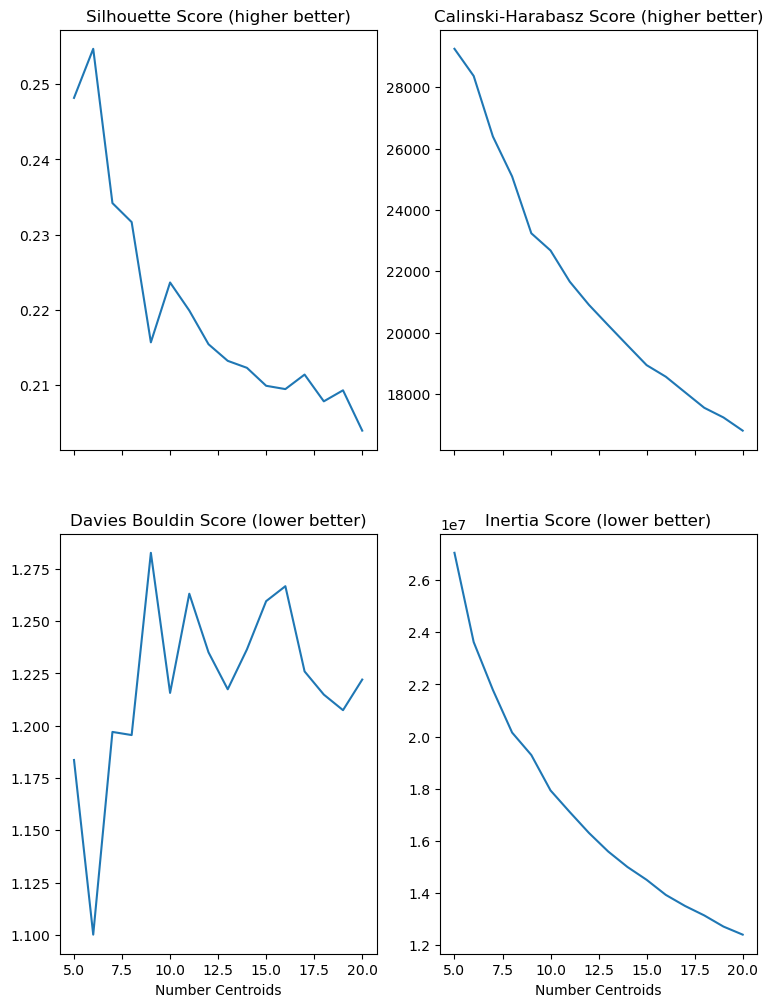

In [13]:
# Now I'll re-run the K-Means clusters, with the new data.
# For the benefit of later steps, where predicting the cluster from the data requires the use of the same column names,
# I'm going to rename the reflected co-ordinates now for these models
kmeans_features = cm_sym_passes_df[["reflected_x1", "reflected_y1", "reflected_x2", "reflected_y2"]].copy()
kmeans_features = kmeans_features.rename(columns={"reflected_x1": "x1", "reflected_y1": "y1", 
                                                  "reflected_x2": "x2", "reflected_y2": "y2"})
clusters = list(range(5, 21, 1))

# K-Means loop results list
models = []
inertias = []
silhouettes = []
calinski_harabasz = []
davies_bouldin = []

# Run k-means for all cluster sizes from 5 to 40 clusters.
for i in tqdm(clusters):
  # Run the kmeans algorithm
  kmeans = cluster.KMeans(n_clusters=i, random_state=seed).fit(kmeans_features)

  # Add the model to the list
  models.append(kmeans)
  # Add all the metrics to the
  inertias.append(kmeans.inertia_)
  silhouettes.append(metrics.silhouette_score(kmeans_features, kmeans.labels_, metric='euclidean'))
  calinski_harabasz.append(metrics.calinski_harabasz_score(kmeans_features, kmeans.labels_))
  davies_bouldin.append(metrics.davies_bouldin_score(kmeans_features, kmeans.labels_))

# Create the metrics figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), sharex=True)

# Silhouette scores
axs[0,0].plot(clusters, silhouettes)
axs[0,0].set_title("Silhouette Score (higher better)")
# Calinski-Harabasz scores
axs[0,1].plot(clusters, calinski_harabasz)
axs[0,1].set_title("Calinski-Harabasz Score (higher better)")
# Davies Bouldin scores
axs[1,0].plot(clusters, davies_bouldin)
axs[1,0].set_title("Davies Bouldin Score (lower better)")
# Inertia scores
axs[1,1].plot(clusters, inertias)
axs[1,1].set_title("Inertia Score (lower better)")

# Label the shared x-axes
axs[1,0].set_xlabel("Number Centroids")
axs[1,1].set_xlabel("Number Centroids")

It looks like 11 centres fits best again so let's see how the plot looks.

Text(0.5, 1.0, 'Reflected Clusters')

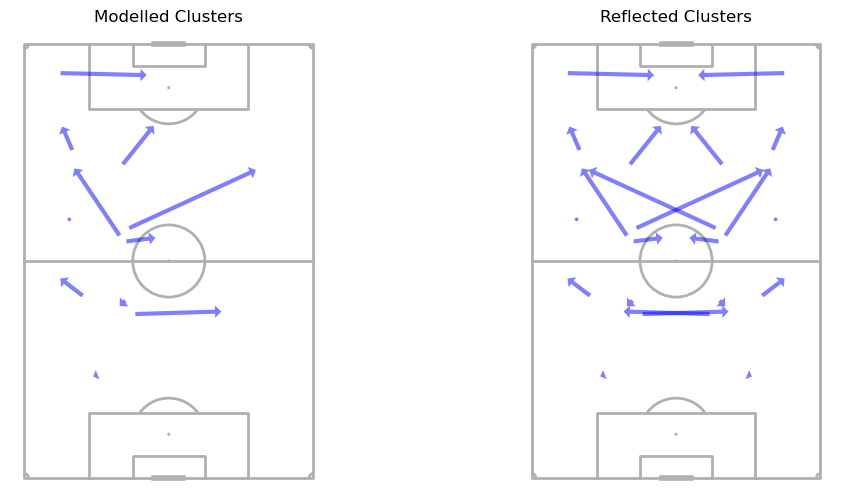

In [14]:
# Create the coordinate values
# cluster_centers[:, 0] and [:, 2] are x values so stay the same
# cluster_centers[:, 1] and [:, 3] are y values so need to be re-configured for plotting
modelled_clusters = np.array([models[6].cluster_centers_[:, 0],
                              models[6].cluster_centers_[:, 1],
                              models[6].cluster_centers_[:, 2],
                              models[6].cluster_centers_[:, 3]]).T

reflected_clusters = np.array([models[6].cluster_centers_[:, 0],
                              40 + (40 - models[6].cluster_centers_[:, 1]),
                              models[6].cluster_centers_[:, 2],
                              40 + (40 - models[6].cluster_centers_[:, 3])]).T
                             

# Set up the figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Create the pitches
# Notice how the axs argument has two parts now - a row index and a column index
pitch = mpl.VerticalPitch(corner_arcs=True)
pitch.draw(ax=axs[0])
pitch.draw(ax=axs[1])

# Loop through each fitted object plotting arrows in the appropriate plot
for coords in modelled_clusters:
  kmeansmod_p0 = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[0],
                              headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
  kmeansmod_p1 = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1],
                              headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in reflected_clusters:
  kmeansref_p1 = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1],
                              headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
    
# Add plot titles
axs[0].set_title("Modelled Clusters")
axs[1].set_title("Reflected Clusters")



This looks much better! We can see some clear patterns of play occurring although there are a couple of weird clusters in there. Before I congratulate myself too much though, I think it would be worthwhile checking how the passes fit the reflected clusters. 

In [17]:
# Create two empty versions of the K-Means model using the sklearn clone() function
modelled_cluster_model = deepcopy(models[6])
reflected_cluster_model = deepcopy(models[6])

# Change the cluster centers and number of clusters for the reflected cluster model
reflected_cluster_model.cluster_centers_ = np.ascontiguousarray(np.vstack((modelled_clusters, reflected_clusters)))
reflected_cluster_model.n_clusters = reflected_cluster_model.cluster_centers_.shape[0]

# Now we can add the cluster predictions to a new dataframe with the player, position and co-ordinates information
# Annoyingly I didn't get the fixture info earlier in the script, so I guess I'll save fixture by fixture comparisons for another time
cm_passes_clustered = passes_df.loc[passes_df["position"].isin(cms)].copy()

# Predict clusters
# Predict the reflected symmetrical clusters with "real" x,y data
cm_passes_clustered["rc_cluster"] = reflected_cluster_model.predict(cm_passes_clustered[["x1", "y1", "x2", "y2"]])
# Predict the left side clusters only, with the reflected training data 
cm_passes_clustered["mc_cluster"] = modelled_cluster_model.predict(kmeans_features)

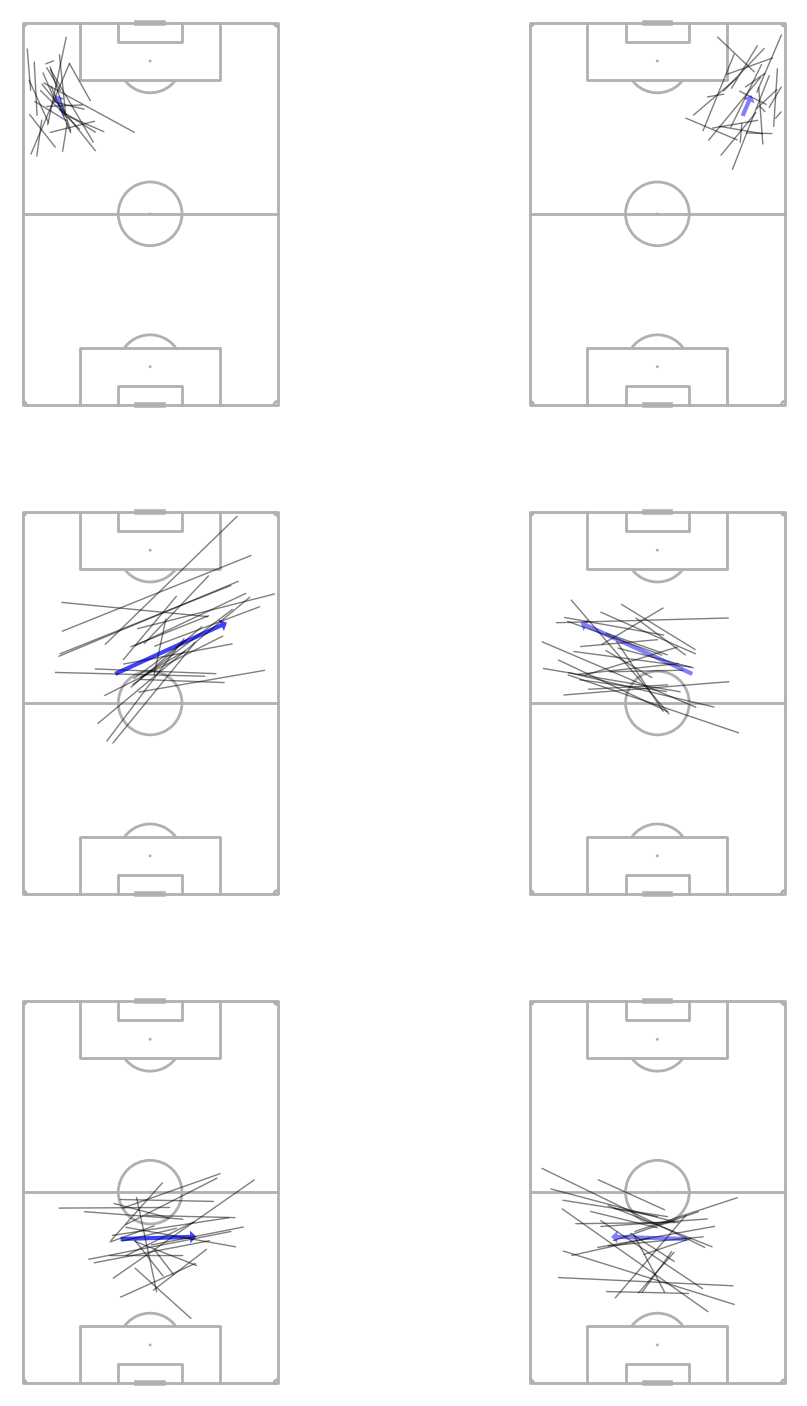

In [18]:
# Set up the figure
# Use a 2x3 plot so reflected centres and their real passes can be plotted side by side
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

# Create the pitches
pitch = mpl.VerticalPitch(corner_arcs=True)

# Draw pitches one by one

# Top left pitch
pitch.draw(ax=axs[0, 0])
# Manually add the cluster of interest
pitch.arrows(xstart = reflected_cluster_model.cluster_centers_[6,0], ystart = reflected_cluster_model.cluster_centers_[6,1],
             xend = reflected_cluster_model.cluster_centers_[6,2], yend = reflected_cluster_model.cluster_centers_[6,3],
             alpha=0.5, color="blue", ax=axs[0, 0],
             headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
# Get a random sample of 100 passes in that cluster
cluster_passes = cm_passes_clustered.loc[cm_passes_clustered["rc_cluster"] == 6][["x1", "y1", "x2", "y2"]].sample(25)
pitch.arrows(xstart = cluster_passes[["x1"]], ystart = cluster_passes[["y1"]],
             xend = cluster_passes[["x2"]], yend = cluster_passes[["y2"]],
             alpha=0.5, color="black", ax=axs[0, 0],
             headaxislength=0.5, headlength=0.5, headwidth=1.0, width=1.0)

# Top right pitch
pitch.draw(ax=axs[0, 1])
pitch.arrows(xstart = reflected_cluster_model.cluster_centers_[17,0], ystart = reflected_cluster_model.cluster_centers_[17,1],
             xend = reflected_cluster_model.cluster_centers_[17,2], yend = reflected_cluster_model.cluster_centers_[17,3],
             alpha=0.5, color="blue", ax=axs[0, 1],
             headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
# Get a random sample of 100 passes in that cluster
cluster_passes = cm_passes_clustered.loc[cm_passes_clustered["rc_cluster"] == 17][["x1", "y1", "x2", "y2"]].sample(25)
pitch.arrows(xstart = cluster_passes[["x1"]], ystart = cluster_passes[["y1"]],
             xend = cluster_passes[["x2"]], yend = cluster_passes[["y2"]],
             alpha=0.5, color="black", ax=axs[0, 1],
             headaxislength=0.5, headlength=0.5, headwidth=1.0, width=1.0)


# Middle left pitch
pitch.draw(ax=axs[1, 0])
# Manually add the cluster of interest
pitch.arrows(xstart = reflected_cluster_model.cluster_centers_[9,0], ystart = reflected_cluster_model.cluster_centers_[9,1],
             xend = reflected_cluster_model.cluster_centers_[9,2], yend = reflected_cluster_model.cluster_centers_[9,3],
             alpha=0.75, color="blue", ax=axs[1, 0],
             headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
# Get a random sample of 100 passes in that cluster
cluster_passes = cm_passes_clustered.loc[cm_passes_clustered["rc_cluster"] == 9][["x1", "y1", "x2", "y2"]].sample(25)
pitch.arrows(xstart = cluster_passes[["x1"]], ystart = cluster_passes[["y1"]],
             xend = cluster_passes[["x2"]], yend = cluster_passes[["y2"]],
             alpha=0.5, color="black", ax=axs[1, 0],
             headaxislength=0.5, headlength=0.5, headwidth=1.0, width=1.0)

# Middle right pitch
pitch.draw(ax=axs[1, 1])
pitch.arrows(xstart = reflected_cluster_model.cluster_centers_[20,0], ystart = reflected_cluster_model.cluster_centers_[20,1],
             xend = reflected_cluster_model.cluster_centers_[20,2], yend = reflected_cluster_model.cluster_centers_[20,3],
             alpha=0.5, color="blue", ax=axs[1, 1],
             headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
# Get a random sample of 100 passes in that cluster
cluster_passes = cm_passes_clustered.loc[cm_passes_clustered["rc_cluster"] == 20][["x1", "y1", "x2", "y2"]].sample(25)
pitch.arrows(xstart = cluster_passes[["x1"]], ystart = cluster_passes[["y1"]],
             xend = cluster_passes[["x2"]], yend = cluster_passes[["y2"]],
             alpha=0.5, color="black", ax=axs[1, 1],
             headaxislength=0.5, headlength=0.5, headwidth=1.0, width=1.0)

# Bottom left pitch
pitch.draw(ax=axs[2, 0])
# Manually add the cluster of interest
pitch.arrows(xstart = reflected_cluster_model.cluster_centers_[10,0], ystart = reflected_cluster_model.cluster_centers_[10,1],
             xend = reflected_cluster_model.cluster_centers_[10,2], yend = reflected_cluster_model.cluster_centers_[10,3],
             alpha=0.75, color="blue", ax=axs[2, 0],
             headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
# Get a random sample of 100 passes in that cluster
cluster_passes = cm_passes_clustered.loc[cm_passes_clustered["rc_cluster"] == 10][["x1", "y1", "x2", "y2"]].sample(25)
pitch.arrows(xstart = cluster_passes[["x1"]], ystart = cluster_passes[["y1"]],
             xend = cluster_passes[["x2"]], yend = cluster_passes[["y2"]],
             alpha=0.5, color="black", ax=axs[2, 0],
             headaxislength=0.5, headlength=0.5, headwidth=1.0, width=1.0)

# Middle right pitch
pitch.draw(ax=axs[2, 1])
pitch.arrows(xstart = reflected_cluster_model.cluster_centers_[21,0], ystart = reflected_cluster_model.cluster_centers_[21,1],
             xend = reflected_cluster_model.cluster_centers_[21,2], yend = reflected_cluster_model.cluster_centers_[21,3],
             alpha=0.5, color="blue", ax=axs[2, 1],
             headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
# Get a random sample of 100 passes in that cluster
cluster_passes = cm_passes_clustered.loc[cm_passes_clustered["rc_cluster"] == 21][["x1", "y1", "x2", "y2"]].sample(25)
pitch.arrows(xstart = cluster_passes[["x1"]], ystart = cluster_passes[["y1"]],
             xend = cluster_passes[["x2"]], yend = cluster_passes[["y2"]],
             alpha=0.5, color="black", ax=axs[2, 1],
             headaxislength=0.5, headlength=0.5, headwidth=1.0, width=1.0)

Although not perfect, this looks to have worked really nicely. There do appear to be a few strange passes included for those we have plotted though. Perhaps adding more clusters, or considering a Gaussian Mixture Model approach could account for this but for now, I'll stick with the model we have as a pretty good representation.